In [1]:
import pandas as pd
import csv
import re
import time
import string
import numpy as np
from sklearn import preprocessing, model_selection, naive_bayes, svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=991899bde0c7f910207de715c9c919f09cdf1e557bcfdeadc249199435299cd6
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark= SparkSession.builder.master("local[*]").getOrCreate()
data=spark.read.csv('Instagram_Ratings.csv',header=True,sep=",")
data.show(5)

+-------+----+------------------+--------------------+--------+
|Column1|  _1|              Name|             Comment|  Rating|
+-------+----+------------------+--------------------+--------+
|      1|NULL|         miguelb_r|Y debemos estar a...|  Neutro|
|      2|NULL|elangeldelmisterio|Por bestias, grac...|Negativo|
|      3|NULL|      angelitals29|             Novedad|  Neutro|
|      4|NULL|    diegoobregon01|que lo defienda @...|  Neutro|
|      5|NULL|       lablanco_ch|    Por qué será?ja!|  Neutro|
+-------+----+------------------+--------------------+--------+
only showing top 5 rows



In [4]:
df=data.toPandas()
print(df)

   Column1    _1                Name  \
0        1  None           miguelb_r   
1        2  None  elangeldelmisterio   
2        3  None        angelitals29   
3        4  None      diegoobregon01   
4        5  None         lablanco_ch   
..     ...   ...                 ...   
93      94  None       aryan.effect_   
94      95  None           chano.106   
95      96  None     denismuchotrigo   
96      97  None         mandyhero14   
97      98  None          janramos65   

                                              Comment    Rating  
0   Y debemos estar agradecidos de estar en el 26 ...    Neutro  
1                   Por bestias, gracias a Reynoso!!!  Negativo  
2                                             Novedad    Neutro  
3               que lo defienda @pedroelinternacional    Neutro  
4                                    Por qué será?ja!    Neutro  
..                                                ...       ...  
93                                       Es una señal    

In [5]:
def clean_text(Comment):
  text=re.sub(r'^RT[\s]+','',Comment)
  text=re.sub(r'https?:\/\/.*[\r\n]*','',Comment)
  text=re.sub(r'#','',Comment)
  text=re.sub(r'@[A-Za-z0-9]+','',Comment)
  return Comment

In [6]:
df['clean_text']=df['Comment'].apply(str)

In [7]:
df['clean_text']=df['clean_text'].apply(clean_text)

In [8]:
df['Comment']

0     Y debemos estar agradecidos de estar en el 26 ...
1                     Por bestias, gracias a Reynoso!!!
2                                               Novedad
3                 que lo defienda @pedroelinternacional
4                                      Por qué será?ja!
                            ...                        
93                                         Es una señal
94                             Gracias Lozano & Reynoso
95    A ver si dejan de darle tanta prioridad al fút...
96                                          Ya se sabía
97                                      Gracias Reinoso
Name: Comment, Length: 98, dtype: object

In [9]:
df

,Column1,_1,Name,Comment,Rating,clean_text
0,1,None,miguelb_r,Y debemos estar agradecidos de estar en el 26 ...,Neutro,Y debemos estar agradecidos de estar en el 26 ...
1,2,None,elangeldelmisterio,"Por bestias, gracias a Reynoso!!!",Negativo,"Por bestias, gracias a Reynoso!!!"
2,3,None,angelitals29,Novedad,Neutro,Novedad
3,4,None,diegoobregon01,que lo defienda @pedroelinternacional,Neutro,que lo defienda @pedroelinternacional
4,5,None,lablanco_ch,Por qué será?ja!,Neutro,Por qué será?ja!
...,...,...,...,...,...,...
93,94,None,aryan.effect_,Es una señal,Neutro,Es una señal
94,95,None,chano.106,Gracias Lozano & Reynoso,Positivo,Gracias Lozano & Reynoso
95,96,None,denismuchotrigo,A ver si dejan de darle tanta prioridad al fút...,Positivo,A ver si dejan de darle tanta prioridad al fút...
96,97,None,mandyhero14,Ya se sabía,Neutro,Ya se sabía


Counter({'Negativo': 43, 'Neutro': 40, 'Positivo': 15})


<Axes: xlabel='Rating', ylabel='count'>

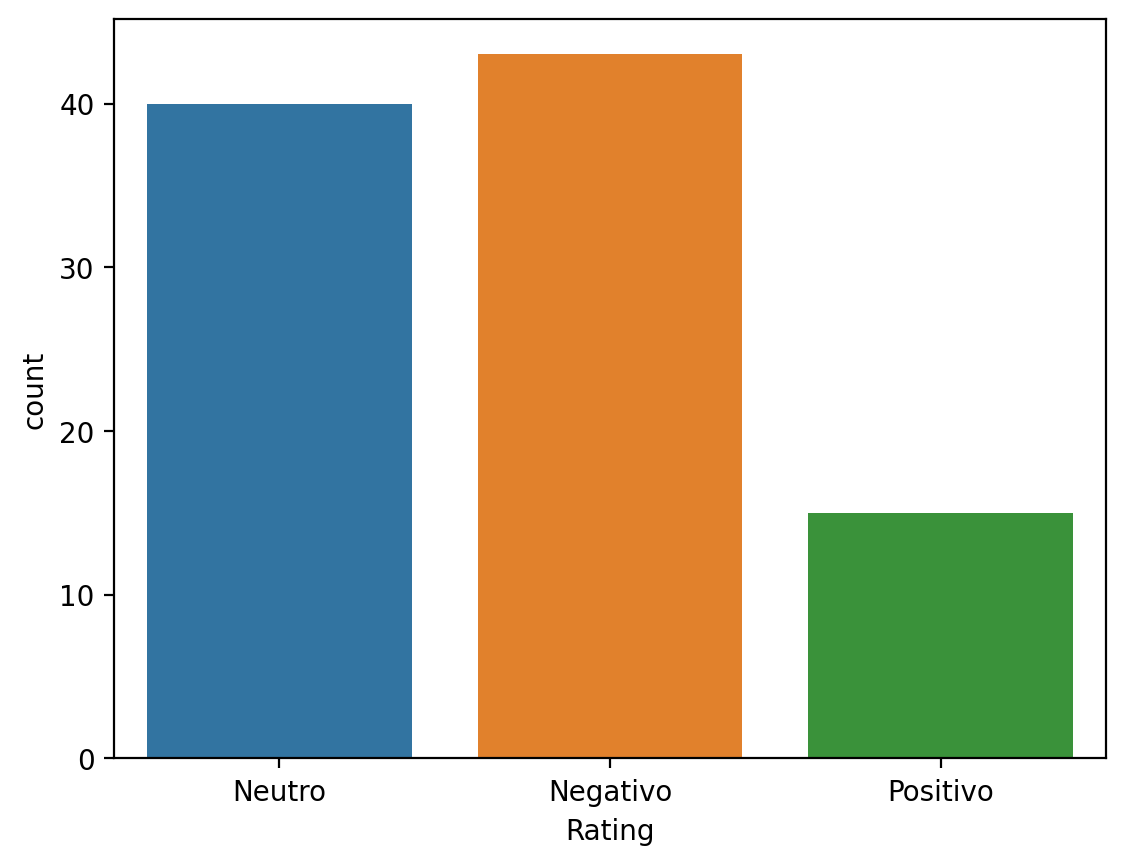

In [10]:
x=df.Comment
y=df.Rating

from collections import Counter
print(Counter(y))
sns.countplot(x=y)

In [11]:
df['RatingInDes']=df.Rating

In [12]:
df.Rating.replace("Positivo",0,inplace=True)
df.Rating.replace("Negativo",1,inplace=True)
df.Rating.replace("Neutro",2,inplace=True)
df.head(10)

,Column1,_1,Name,Comment,Rating,clean_text,RatingInDes
0,1,None,miguelb_r,Y debemos estar agradecidos de estar en el 26 ...,2,Y debemos estar agradecidos de estar en el 26 ...,Neutro
1,2,None,elangeldelmisterio,"Por bestias, gracias a Reynoso!!!",1,"Por bestias, gracias a Reynoso!!!",Negativo
2,3,None,angelitals29,Novedad,2,Novedad,Neutro
3,4,None,diegoobregon01,que lo defienda @pedroelinternacional,2,que lo defienda @pedroelinternacional,Neutro
4,5,None,lablanco_ch,Por qué será?ja!,2,Por qué será?ja!,Neutro
5,6,None,giancarlorocka,Ese Ranking no sirve pero ni pa ir ñoba. Pero...,1,Ese Ranking no sirve pero ni pa ir ñoba. Pero...,Negativo
6,7,None,cesarjjs_20,Merecido xd,2,Merecido xd,Neutro
7,8,None,fernandoesqboy,Es más que ya ni jueguen xd,2,Es más que ya ni jueguen xd,Neutro
8,9,None,anthoniobc1981,Gracias Reynoso!!,0,Gracias Reynoso!!,Positivo
9,10,None,djulca,Agradescanle al entrenador sin ideas,1,Agradescanle al entrenador sin ideas,Negativo


In [13]:
dfNew=df[['clean_text','Rating']]
dfNew.head()

,clean_text,Rating
0,Y debemos estar agradecidos de estar en el 26 ...,2
1,"Por bestias, gracias a Reynoso!!!",1
2,Novedad,2
3,que lo defienda @pedroelinternacional,2
4,Por qué será?ja!,2


<function matplotlib.pyplot.show(close=None, block=None)>

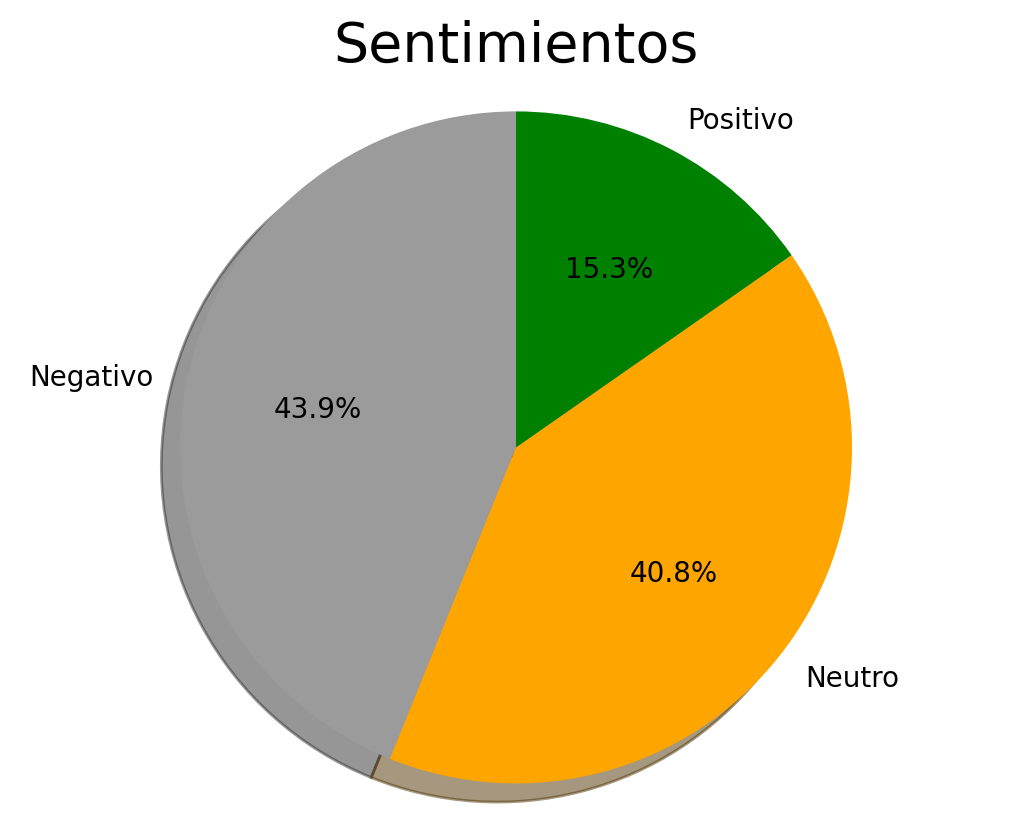

In [14]:
import matplotlib.pyplot as plt
labels='Negativo','Neutro','Positivo'
colors=['#9b9b9b','Orange','Green']
plt.pie(dfNew['Rating'].value_counts(),labels=labels,colors=colors,autopct='%1.1f%%',shadow=True,startangle=90)
plt.title('Sentimientos',fontsize=20)
plt.axis('equal')
plt.show

In [15]:
!pip install googletrans==3.1.0a0
from googletrans import Translator, LANGUAGES
translator = Translator()

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.2 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16351 sha256=cddf696f75609014c3413c8c659391d390abd556837a00e271eacfcf5dcabad9
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling cha

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [16]:
def analizar_sentimiento(texto):
  translated_text = translator.translate(texto, src="es", dest="en")
  sid=SentimentIntensityAnalyzer()
  sentimiento=sid.polarity_scores(translated_text.text)["compound"]
  if(sentimiento>0.1):
    return "Positivo"
  elif sentimiento <0:
    return "Negativo"
  else:
    return "Neutro"

In [17]:
sentimiento=analizar_sentimiento("Esta bien")
print(sentimiento)

Positivo


In [18]:
dfNew['ratingForModel']=dfNew['clean_text'].apply(analizar_sentimiento)
dfNew.head()

<ipython-input-18-59be4a98b0b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfNew['ratingForModel']=dfNew['clean_text'].apply(analizar_sentimiento)


,clean_text,Rating,ratingForModel
0,Y debemos estar agradecidos de estar en el 26 ...,2,Positivo
1,"Por bestias, gracias a Reynoso!!!",1,Positivo
2,Novedad,2,Neutro
3,que lo defienda @pedroelinternacional,2,Neutro
4,Por qué será?ja!,2,Positivo


Counter({'Neutro': 46, 'Positivo': 35, 'Negativo': 17})


<Axes: xlabel='ratingForModel', ylabel='count'>

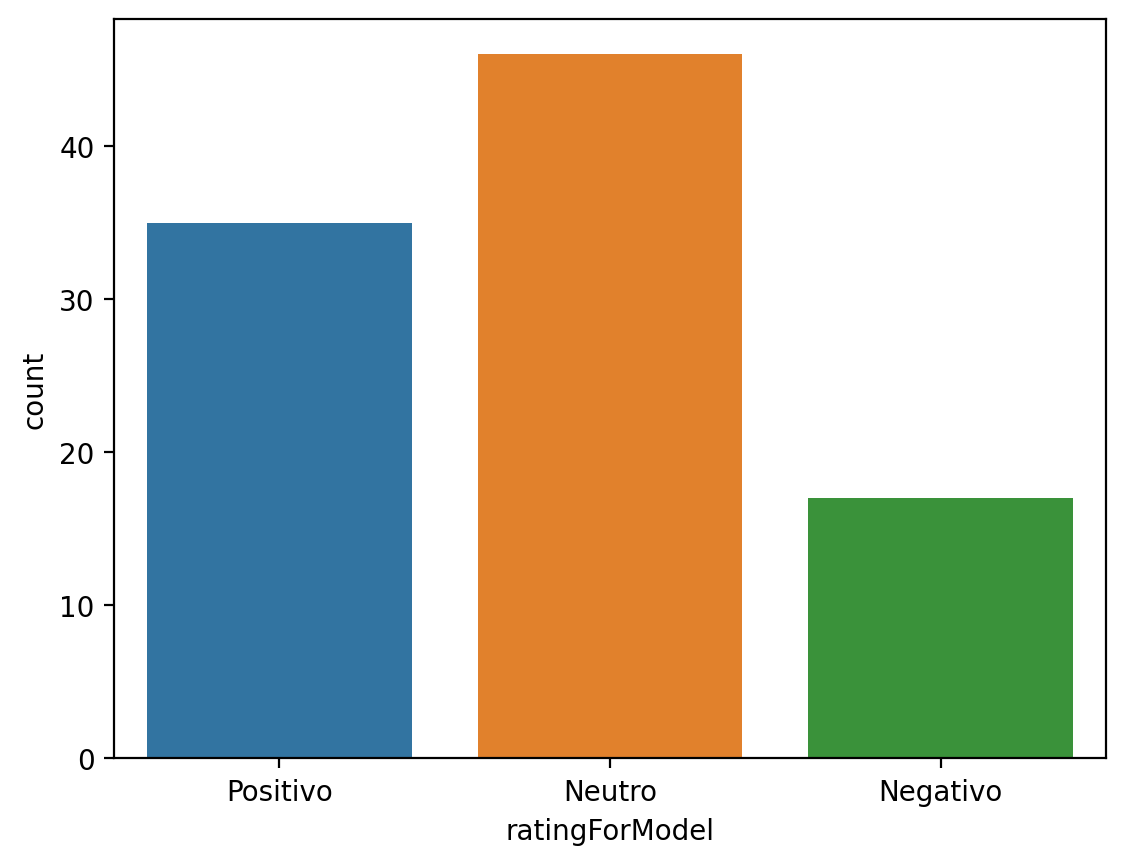

In [19]:
x=dfNew.clean_text
y=dfNew.ratingForModel

from collections import Counter
print(Counter(y))
sns.countplot(x=y)

In [20]:
reporte=classification_report(df['RatingInDes'],dfNew['ratingForModel'])
print(reporte)

              precision    recall  f1-score   support

    Negativo       0.76      0.30      0.43        43
      Neutro       0.59      0.68      0.63        40
    Positivo       0.40      0.93      0.56        15

    accuracy                           0.55        98
   macro avg       0.58      0.64      0.54        98
weighted avg       0.64      0.55      0.53        98

